# Julia version of bonding models for PES !!

### Basic Optimization tests

In [2]:
using Optim, LsqFit # opt libs
using LinearAlgebra # self explanatory
using Zygote, ReverseDiff # autodiff
using Plots, LaTeXStrings # plots
using StatsBase, DataStructures, DelimitedFiles, MLUtils, BenchmarkTools, NPZ, StaticArrays # utils
"""
possible efficiency opt: https://github.com/JuliaArrays/StaticArrays.jl
for checking allocs: 
 - https://github.com/KristofferC/TimerOutputs.jl
 - https://discourse.julialang.org/t/way-to-show-where-memory-allocations-occur/2161
"""

In [2]:
# functional form:
function f_ratpot_2(Θ, R, M)
    #=
    ansatz 1 for diatomic potential
    params:
        - Θ := training parameters, vector ()
        - R := distances, vector
    =#
    # unroll coefficients
    a = Θ[1:M]
    b = Θ[M+1:2*M]
    c = Θ[2*M+1:3*M+4]
    d = Θ[3*M+5:4*M+7]
    
    # b_i ≥ 0 for i > 1:
    t = b[2:M]
    bool = t .< 0.
    t[bool] = -t[bool]
    b[2:M] = t
    
    # d_i ≥ 0 for i > 0:
    bool = d .< 0.
    d[bool] = -d[bool]    
    
    # evaluate P:
    P = c[end-1]
    P = P .* ((R .- a[1]).^2 .+ (b[1] .* R))
    for i=2:M
        P .*= (R .- a[i]).^2 .+ (b[i]*R)
    end

    
    # eval Q:
    Q = (R .+ d[end]).*R
    for i=1:M+2
        Q .*= (R .- c[i]).^2 .+ d[i].*R
    end
    
    # eval potential:
    V = c[end] .+ (P ./ Q)
    return V
end

f_RMSE(X, Y) = √(sum((X .- Y) .^ 2)/length(X))

function f_least_squares(f_eval, Y, f_args...)
    Y_pred = f_eval(f_args...)
    res = sum((Y .- Y_pred).^2)
    return res
end

f_least_squares (generic function with 1 method)

#### Optimize ratpot 2 !!

In [3]:
# prepare data:
H_data = readdlm("data/h2/h2_ground_w.txt")
R = H_data[:, 1]; V = H_data[:, 2]
Xs, Ys = shuffleobs((R, V))
train_data, test_data = splitobs((Xs, Ys); at=0.8)
R_train = copy(train_data[1]); V_train = copy(train_data[2]);
R_test = copy(test_data[1]); V_test = copy(test_data[2]);

# tuning parameters:
M = 20
ub = 10; lb = 0
θ = rand(4*M+7) .* (ub-lb) .+ lb # random between [a, b] = [-1, 1]
#println(f_ratpot_2(θ, R_train, M))
f_least_squares(f_ratpot_2, V_train, θ, R_train, M)

4404.864370899371

In [ ]:
# optimize:

res = optimize(θ -> f_least_squares(f_ratpot_2, V_train, θ, R_train, M),
                θ, BFGS(),
                Optim.Options(iterations = 2000, show_trace=true); 
                autodiff = :forward
                )

In [5]:
# check RMSE:
V_pred = f_ratpot_2(res.minimizer, R_train, M)
println(f_RMSE(V_train, V_pred))
V_pred = f_ratpot_2(res.minimizer, R_test, M)
println(f_RMSE(V_test, V_pred))
for i=1:length(V_test)
    println(V_pred[i]," ",V_test[i])
end

4.234704519894572e-6
2.9276919358380464e-6
-0.0008473614097407878 -0.0008457269999999628
-0.07954291804404812 -0.07954594900000012
-0.1519622732506834 -0.15195909900000015
-0.11653569803675493 -0.1165328080000001
-0.03391427554983345 -0.03391220100000014
-0.005351304696011028 -0.005348754000000122
-0.16747835744279463 -0.16748270900000017
-0.17098887938290577 -0.17099233300000005
-5.478405504333317e-5 -5.306299999996433e-5
-0.031062824242911735 -0.031061373000000003
-0.010857211378577925 -0.010857708000000077
-0.026627807954423488 -0.026627746000000174
-0.15506383270077323 -0.15506615300000015
-0.07577424840002328 -0.07577727099999998
-8.232465193436234e-6 -6.208000000063052e-6
-0.0006030500384439641 -0.0006003549999999969
-0.0010596603561299767 -0.001059486000000165
-0.01959761557770706 -0.019599871000000046
-9.81964487805631e-5 -9.699600000012687e-5
-0.021836953193801134 -0.02183858500000002
-0.15661983418865094 -0.15662260100000003
-0.03696914403296936 -0.036966681
-0.16865910473891

## New bonding features (bump functions)

#### obtaining $z(t)$ coefficients

In [2]:
#=
these primitive features replaces the b array, z is equivalent to b_1 (d=1), while f is d ≥ 2
=#
# test the z function derivation:
A = [1 1 1 -1; 1 -1 -1 1; 0 -1 -5 3; 0 0 20 -6]
b = [1 0 0 0]'
r = A\b

4×1 Matrix{Float64}:
 0.5
 0.9375
 0.18750000000000006
 0.6250000000000001

### 1. $z(t)$ coordinate function

In [3]:
# z(t) coordinate function:
function z_coord(t)
    """
    vanilla version is more preferred, use map(f, .) for vector/array, much faster than the vectorized version
    """
    t = max(-1.,min(t,1.))
    t2 = t^2
    z = 0.5 - t*(0.9375 + t2*(0.1875*t2 - 0.625))
    return z
end

function z_coord_vec(t)
    """
    vectorized version, for benchmark
    """
    z = zeros(Float64, size(t)) # default values, t ≥ 1
    t .= max.(-1.,(min.(1.,t)))
    t2 = t.^2
    z .= @. 0.5 - t*(0.9375 + t2*(0.1875*t2 - 0.625))
    return z
end


# manual by hand derivatives:
∂z_coord(t) = @. -0.9375 - 0.9375*(t^4) + 1.875*(t^2)
∂∂z_coord(t) = @. -3.75*(t^3) + 3.75*t


# autodiff derivatives:
∂z_coord_auto(t) = map(x -> x[1], map(x -> Zygote.gradient(z_coord, x), t)) 
∂∂z_coord_auto(t) = map(x -> Zygote.hessian(z_coord, x), t)


function _∂z_coord_auto(t)
    """
    !! UNUSED !!
    """
    # compute gradient:
    df = x -> map(y-> Zygote.gradient(z_coord, y), x)
    ∂z_auto = df(t)
    # convert nothing to 0, since we know the derivative at lb and ub is 0
    ∂z_auto = map(x->x[1], ∂z_auto)
    bool = ∂z_auto .== nothing
    if sum(bool) == length(bool)
        ∂z_auto = zeros(length(bool))
    else
        ∂z_auto[bool] .= 0. 
    end
    ∂z_auto = convert(Vector{Float64}, ∂z_auto)
    return ∂z_auto
end

function _dz(x)
    """
    !! UNUSED !!
    special autodiff for 1st derivative, function to handle "nothing", since Hessian() function doesn't handle it explicitly
    """
    dx = Zygote.gradient(z_coord, x)[1]
    if dx == nothing
        dx = 0.
    end
    return dx
end

function _∂∂z_coord_auto(t)
    """
    !! UNUSED !!
    """
    # compute 2nd derivative:
    ∂∂z_auto = map(x -> Zygote.gradient(dz, x), t)
    # replace nothings with 0s:
    ∂∂z_auto = map(x->x[1], ∂∂z_auto)
    bool = ∂∂z_auto .== nothing
    if sum(bool) == length(bool)
        ∂∂z_auto = zeros(length(bool))
    else
        ∂∂z_auto[bool] .= 0. 
    end
    ∂∂z_auto = convert(Vector{Float64}, ∂∂z_auto)
    return ∂∂z_auto
end


_∂∂z_coord_auto (generic function with 1 method)

In [375]:
t0 = [-1., 1.]
println(map(z_coord, t0))
println(∂z_coord(t0), ∂z_coord_auto(t0))
println(∂∂z_coord(t0), ∂∂z_coord_auto(t0))

# autodiff but very ineffficient way, just for checking): 
#println(map(x -> ReverseDiff.jacobian(z_coord, [x]), t0))
#println(map(x -> ReverseDiff.hessian(z_coord, [x]), t0))

# for plot:
t = collect(LinRange(-3., 3., Int(1e5)))

z = map(z_coord, t);
∂z = ∂z_coord_auto(t);
∂∂z = ∂∂z_coord_auto(t);

[1.0, 0.0]
[0.0, 0.0][0.0, 0.0]
[0.0, 0.0][0.0, 0.0]


#### some benchmarks

In [284]:
@benchmark z_coord_vec(t)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  274.587 μs …   6.066 ms  ┊ GC (min … max):  0.00% … 93.86%
 Time  (median):     309.045 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   384.511 μs ± 574.163 μs  ┊ GC (mean ± σ):  16.59% ± 10.35%

  █▄                                                            ▁
  ███▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇ █
  275 μs        Histogram: log(frequency) by time       5.38 ms <

 Memory estimate: 1.53 MiB, allocs estimate: 4.

In [283]:
@benchmark map(z_coord, t) #interesting, using map is several times faster and use much less memory

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   98.528 μs …   5.728 ms  ┊ GC (min … max):  0.00% … 92.82%
 Time  (median):     106.542 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   144.249 μs ± 404.888 μs  ┊ GC (mean ± σ):  21.96% ±  7.63%

  ▃█▇▅▅▄▃▃▃▂▁                                                 ▁ ▂
  ████████████▇▇▆▅▆▅▄▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▆█ █
  98.5 μs       Histogram: log(frequency) by time        335 μs <

 Memory estimate: 781.34 KiB, allocs estimate: 3.

In [346]:
@benchmark _∂z_coord_auto(t)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  627.905 ms … 659.130 ms  ┊ GC (min … max): 3.79% … 7.73%
 Time  (median):     642.559 ms               ┊ GC (median):    5.75%
 Time  (mean ± σ):   642.813 ms ±  14.586 ms  ┊ GC (mean ± σ):  5.77% ± 1.96%

  ███   █                                           █   ██    █  
  ███▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁██▁▁▁▁█ ▁
  628 ms           Histogram: frequency by time          659 ms <

 Memory estimate: 248.58 MiB, allocs estimate: 7283342.

In [376]:
@benchmark ∂z_coord_auto(t)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  257.359 μs …   6.466 ms  ┊ GC (min … max):  0.00% … 89.28%
 Time  (median):     274.291 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   345.835 μs ± 597.782 μs  ┊ GC (mean ± σ):  18.21% ±  9.95%

  █   ▁                                                         ▁
  ██▅▁█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ █
  257 μs        Histogram: log(frequency) by time       5.88 ms <

 Memory estimate: 1.53 MiB, allocs estimate: 4.

In [347]:
@benchmark _∂∂z_coord_auto(t) #using jacobian or hessian is much more faster, however unable to handle non-smoothnes

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 26.495 s (2.88% GC) to evaluate,
 with a memory estimate of 5.26 GiB, over 137232885 allocations.

In [352]:
@benchmark ∂∂z_coord_auto(t)

BenchmarkTools.Trial: 2916 samples with 1 evaluation.
 Range (min … max):  1.559 ms …   7.947 ms  ┊ GC (min … max): 0.00% … 75.11%
 Time  (median):     1.654 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.710 ms ± 437.926 μs  ┊ GC (mean ± σ):  1.85% ±  5.72%

  █ ▁                                                          
  █▂█▇▅▇▅▅▄▃▅▄▄▄▄▃▄▄▃▄▃▃▃▃▃▃▃▂▃▃▃▄▃▂▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.56 ms         Histogram: frequency by time        2.04 ms <

 Memory estimate: 781.33 KiB, allocs estimate: 2.

#### z, z', z'' plots using dummy data

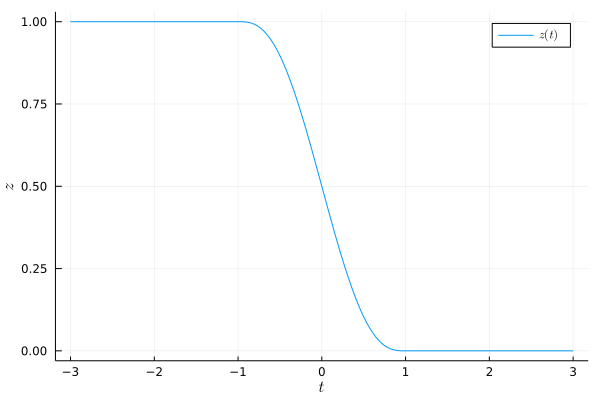

In [377]:
# plot z, z', z'':
plot(t, z, label = L"z(t)")
xlabel!(L"t"); ylabel!(L"z")

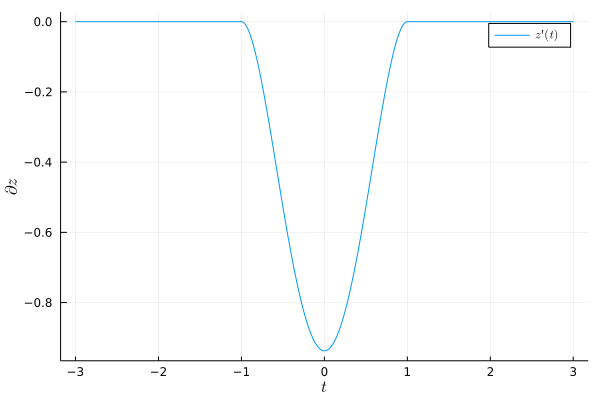

In [378]:
plot(t, ∂z, label = L"$z'(t)$")
xlabel!(L"$t$"); ylabel!(L"$\partial z$")

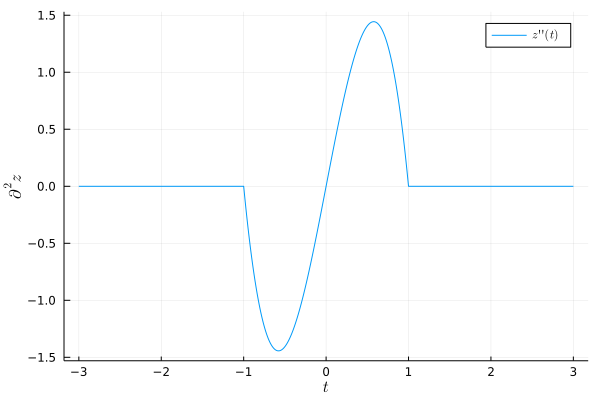

In [379]:
plot(t, ∂∂z, label = L"$z''(t)$")
xlabel!(L"$t$"); ylabel!(L"$\partial^2 z$")

### 2. $f_k(t)$ bump functions

In [4]:
function r_eq(R, q, dof)
    """
    !! UNUSED !!
    computes the equilibrium point of each distance vector,
    returns:
        - r_xy: vector of equilibrium distances with shape (dof)
    params:
        - R, matrix of distances with shape (dof, n_data)
        - q, quantile, [0,1] ∈ Real scalar
        - dof, scalar, ∈ Z scalar
    """
    r_xy = map(i -> quantile((@view R[i,:]), 0.3), 1:dof)
    return r_xy
end

function f_bump(t, k)
    """
    bump function,
    returns: 
        - b, f(t,k), real scalar
    params:
        - t, scalar ∈ R
        - k, scalar ∈ Z
    """
    """
    OLD VER, uncompatible with AD due to explicit constants:
    b = 0. # zeros outside [t_low, t_high]
    if t ≥ k-1. && t ≤ k + 1.
        b = (1. - (t-k)^2)^3
        # take only the positive part:
        b < 0. ? b =-b : b
    end
    """
    tlow = k - 1.; thi = k + 1.;
    t = max(tlow, min(thi, t))
    b = (1. - (t-k)^2)^3
    b = max(-b, b)
    return b
end

f_t(c_xy, r2_stat, R2) = c_xy*(R2 .- r2_stat) # takes r2 := r^2 vector, rest are scalars
f_t_scalar(c_xy, r2_stat, r2) = c_xy*(r2 - r2_stat) # scalar version of f_t
f_c(N, r2_hi, r2_low) = N/(r2_hi - r2_low) # scalar ops
f_k(t_low, t_hi) = collect(round(t_low):round(t_hi))[2:end-1] # generate a list of k ∈ Z ∩ t_low < k < t_hi

f_k (generic function with 1 method)

### 3. main caller for z and bump

In [5]:
sqr(x) = x^2 # abstraction fun of x^2

function f_z_bump(R, r_xy, N)
    """
    computes the z(t) and bump function and stacks them into one array for one unique xy atomic pair.
    - returns (n_data, n_d, n_k = k+1) array, where [:,:,k+1] contains z, the rest are bumps.
    d here is actually ⊂ d, since there would be another z(t) and bump calculation if the molecule is heterogeneous, e.g.,
    H2O: (HH, HO, HO) -> (1 c_HH, 2 c_HO), it means the array's sizes would be c_HH: (n_data, 1, k+1), c_HO: (n_data, 2, k+1),
    stacked into z_bumo_mat: (n_data, 3, k+1) total size.
    params:
        - R, subset of matrix of distances, (n_data, n_d) shape, ∈ Float64
        - r_xy, equilibrium distance of pairpot xy, const scalar ∈ real
        - N, hyperparam: num of bumps, scalar ∈ int
    """
    #these need to be moved outside of the function, since for hetero mol these would be needed for other primitive features.
    r2_xy = r_xy^2; r2_hi = maximum(R)^2; r2_low = minimum(R)^2; 
    # R2 = R.^2
    R2 = map(sqr, R)
    # t_xy:
    n_data = size(R2)[1]; n_d = size(R2)[2];
    c_xy = f_c(N, r2_hi, r2_low)
    t_xy = map(i -> f_t(c_xy, r2_xy, (@view R2[:,i])), 1:n_d) # t of equilibrium distance vector{n_d}(vector{n_data})
    t_xy = mapreduce(permutedims, vcat, t_xy)
    t_xy = transpose(t_xy)
    t_low = f_t_scalar(c_xy, r2_xy, r2_low)
    t_hi = f_t_scalar(c_xy, r2_xy, r2_hi)
    k = f_k(t_low, t_hi); k_idx = convert(Array{Int}, k)
    
    n_k = length(k); 
    output_mat = Array{Float64}(undef, n_data, n_d, n_k+1) # contains (n_data, d, k+1) array, [:,:,k+1] is z
    # bump:
    range_n_data = 1:n_data; range_n_d = 1:n_d
    for i = k_idx
        out = map(x -> f_bump(x, k[i]), t_xy) # map on matrix
        output_mat[:,:,i] = out
    end

    # z:
    z = map(z_coord, t_xy)
    output_mat[:, :, end] = z;
    #return output_mat, t_xy
    return output_mat
end

f_z_bump (generic function with 1 method)

### 4. Primitive features using H$_3$ data (only numerical outputs - no fitting yet)

#### Data preprocessing

In [6]:
H_data = readdlm("data/h3/h3_data.txt")
# load example:
H_coord = npzread("data/h3/h3_coord.npy")
R = transpose(H_data[:, 1:end-1]); V = H_data[:, end] # transpose to match dimension
Xs, Ys = shuffleobs((R, V))
println(size(Xs), size(Ys))
train_data, test_data = splitobs((Xs, Ys); at=0.8) # ∈ 5-fold
R_train = copy(train_data[1]); R_train = transpose(R_train); # transpose back because julia is column dominant
V_train = copy(train_data[2])
R_test = copy(test_data[1]); R_test = transpose(R_test);
V_test = copy(test_data[2])
println(size(R_train), size(V_train))
R = H_data[:, 1:end-1] # return R for later use
println(typeof(R))
println(size(H_coord), "data, atom, elem")
println(R[1,3])
println(norm(H_coord[1,2,:] - H_coord[1,3,:]))

(3, 6032)(6032,)
(4826, 3)(4826,)
Matrix{Float64}
(6032, 3, 3)data, atom, elem
1.335106
1.335106


In [9]:
# r_xy, r_low, r_hi:
r_xy = 1.4172946 # for HH, from http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/diatomic.html
# since H3 is homogeneous, can use all columns:
r_hi = maximum(R_train)
r_low = minimum(R_train)
r2_xy = r_xy^2; r2_hi = r_hi^2; r2_low = r_low^2;

# array sizes:
dof = size(R_train)[2] # number of columns in R matrix
R2 = R_train.^2;

#### <li> $z,z',z''$ and bump plots with $N=2,3,5,10,20$

In [ ]:
# using range data [tlow-2, thi+2]
for N=[5, 10]
    c_xy = f_c(N, r2_hi, r2_low)
    t_xy = map(i -> f_t(c_xy, r2_xy, (@view R2[:,i])), 1:dof) # t of equilibrium distance
    t_low = f_t_scalar(c_xy, r2_xy, r2_low)
    t_hi = f_t_scalar(c_xy, r2_xy, r2_hi)
    k = f_k(t_low, t_hi)

    t_range = collect(LinRange(t_low-2., t_hi+2., Int(1e5))) # between tlow-2 and thi+2
    
    # z:
    z = map(z_coord, t_range);
    
    # bump for each k:
    output_mat = Array{Float64}(undef, length(t_range), length(k)+1)
    labels = String[]
    for i=k
        idx = Int(i)
        output_mat[:, idx] = map(j -> f_bump(t_range[j], i), 1:length(t_range))
        push!(labels, "k = "*string(k[idx]))
    end
    output_mat[:, end] = z
    push!(labels, "z")
    labels = reshape(labels, 1, length(labels)) # convert to matrix datastruct
    display(plot(t_range, output_mat, lw = 1, xlabel=L"$t$", ylabel=L"$f$", title = "z and bump, N="*string(N), label=labels,
            yticks = -1.:0.25:2., ylims = (-.5,1.5)))
end

In [679]:
N = 5
output_mat, t_xy = f_z_bump(R_train, r_xy, N) # using custom return: t_xy, for plot
println(size(t_xy))
didx = 3
sort_idx = sortperm(t_xy[:,didx])
t_sort = t_xy[:,didx][sort_idx]
output = output_mat[:,didx,:]
output = map(i -> output[:,i][sort_idx], 1:size(output)[2])
display(plot(t_sort, output, lw = 1, xlabel=L"$t$", ylabel=L"$f$", title = "z and bump, N="*string(N), yticks = -1.:0.25:2., ylims = (-.5,1.5)))

()


LoadError: MethodError: no method matching getindex(::Float64, ::Colon, ::Int64)
[0mClosest candidates are:
[0m  getindex(::Number, [91m::Integer...[39m) at D:\Julia-1.7.2\share\julia\base\number.jl:101
[0m  getindex(::Number) at D:\Julia-1.7.2\share\julia\base\number.jl:95
[0m  getindex(::Union{AbstractChar, Number}, [91m::CartesianIndex{0}[39m) at D:\Julia-1.7.2\share\julia\base\multidimensional.jl:831
[0m  ...

In [10]:
zb_mat = f_z_bump(R, 1.4172946, 5)
@benchmark f_z_bump(R, r_xy, 5)

BenchmarkTools.Trial: 7172 samples with 1 evaluation.
 Range (min … max):  377.600 μs …   6.100 ms  ┊ GC (min … max):  0.00% … 86.07%
 Time  (median):     454.200 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   695.001 μs ± 525.129 μs  ┊ GC (mean ± σ):  12.14% ± 14.21%

  █▂      ▅▆▅▄▃▂▁                                               ▁
  ████████████████▇▆▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▅▅▄▆▆▆▆█▇▇▇▆▇▆ █
  378 μs        Histogram: log(frequency) by time       3.16 ms <

 Memory estimate: 2.03 MiB, allocs estimate: 40.

### Pre-computation Utils

In [11]:
"""
use distance to coord implementation in Py for now. Load the files using NPZ
"""


function atom_indexer(n_atom)
    """
    generates array of coordination indexes for Y[i] vector, which depends on num_atom, e.g.:
    num_atom = 3:  [[1,2],[1,3],[2,3]]
                     b_1j  b_2j b_3j
    num_atom = 4: [[1,2,3],[1,4,5],[2,4,6],[3,5,6]]
                    b_1j     b_2j   b_3j     b_4j
    in form of Matrix{Int}(n_atom-1,n_atom), ordered by column (column dominant)
    """
    init_idx = collect(n_atom:-1:2)
    group_idx = []
    start = 1
    for idx=init_idx
        list_index = collect(start:idx+start-2)
        push!(group_idx, list_index)
        start += idx - 1
    end
    coord_idx = []
    for i=range(1, step=1, n_atom)
        coord = []
        if i == 1
            coord = group_idx[1]
            push!(coord_idx, coord)
        elseif i == n_atom
            enumerator = collect(range(i-1, step=-1, 1))
            counter = 1
            for num=enumerator
                push!(coord, group_idx[counter][num])
                counter += 1
            end
            push!(coord_idx, coord)
        else
            enumerator = collect(range(i-1, step=-1, 1))
            counter = 1
            for num=enumerator
                push!(coord, group_idx[counter][num])
                counter += 1
            end
            append!(coord, group_idx[counter])
            push!(coord_idx, coord)
        end
    end
    coord_idx = transpose(mapreduce(permutedims, vcat, coord_idx))
    coord_idx = convert(Matrix{Int}, coord_idx)
    return coord_idx
end

atom_indexer (generic function with 1 method)

### Bonding features: $U, Y(z(t), f_\text{bump}), G(z(t), f_\text{bump})$

In [20]:
function f_Y_coord(z_bump_mat, idxer)
    """
    Y_d[i] = sum_{j neq i}b_{ijd}
    returns an array with shape = (n_data, n_k, n_atom)
    params:
        - z_bump_mat, array containing z(t) and bump functions, shape = (n_data, n_d, n_k) ∈ Float64
        - idxer, matrix containing the indexer required for 2-body sums, shape = (n_atom-1, n_atom)
    """
    n_data, n_d, n_k = size(z_bump_mat); n_atom = size(idxer)[2]
    Y_mat = Array{Float64}(undef, (n_data, n_k, n_atom))
    # 2-body sums for each atom:
    for i=1:n_atom
        atom_arr = @view z_bump_mat[:, idxer[:,i],:]
        Y_mat[:,:,i] = sum(atom_arr, dims=2)
    end
    return Y_mat
end

function f_Δcoord(X)
    """
    X_j - X_i, i \neq j
    returns: Δ array containing the differences of the coordinates, shape = (n_data, n_elem=3, n_d) ∈ Float64
    params:
    - X, matrix containing coordinates of the atoms, shape = (n_data, n_atom, 3)
    """
    n_data, n_atom, n_elem = size(X)
    n_d = Int((n_atom^2 - n_atom)/2)
    Δ = Array{Float64}(undef, (n_data, n_elem, n_d))
    X = permutedims(X, [1,3,2]) # move axis, becomes (n_data, 3, n_atom)
    rg_atom = 1:n_atom
    d = 1
    for i=rg_atom
        for j=rg_atom
            if i<j
                x_j = @view X[:,:,j]; x_i = @view X[:,:,i]
                Δ[:,:,d] = x_j - x_i #X_j - X_i
                d += 1
            end
        end
    end
    #Δ = permutedims(Δ, [2,1,3]) # move axis again, becomes (3, n_data, n_atom)
    return Δ
end

svmul(c, x) = c*x
function f_r_orient_vec(z_bump, Δ, idxer)
    """
    r_d[i] ∈ R^3 = sum(z_bump_ij*Δ_ij) -> scalar*vector
    returns: array of r, shape = (3, n_data, n_k, n_atom)
    params:
        - z_bump_mat, array containing z(t) and bump functions, shape = (n_data, n_d, n_k) ∈ Float64
        - Δ, array containing the differences of the coordinates, shape = (n_data, 3, n_d) ∈ Float64
        - idxer, matrix containing the atomic indexer, shape = (n_atom-1,n_atom) ∈ Int
    """
    n_data, n_d, n_k = size(z_bump); n_atom = size(idxer)[2]
    temp_out = Array{Float64}(undef, 3, n_data, n_d, n_k)
    rg_k = 1:n_k; rg_j = 1:n_d; rg_i=1:n_data
    # vanilla loop for z[i,j,k]*Δ[i,:,j]:
    Δ = permutedims(Δ, [2,1,3]) # put vector length to front
    for k=rg_k
        for j=rg_j
            @simd for i=rg_i
                Δ_ij = @view Δ[:,i,j]
                @inbounds temp_out[:,i,j,k] = z_bump[i,j,k]*Δ_ij
            end
        end
    end
    # ∑z*Δ, 2-body sums for each atom:
    rk = Array{Float64}(undef, n_elem, n_data, n_k, n_atom)
    temp_out = permutedims(temp_out, [1,2,4,3]) # move the op to the back
    for i=1:n_atom
        atom_arr = @view temp_out[:,:,:,idxer[:,i]]
        @inbounds rk[:,:,:,i] = sum(atom_arr, dims=4)
    end
    return rk
end

function f_G_mat(rk)
    """
    G[i]_k1k2 ∈ R = r_k1[i] ⋅ r_k2[i]
    returns:
        - G, array from dot product of rk, shape = (n_data, n_k, n_k, n_atom)
    params:
        - rk, array of orientation vectors, shape = (3, n_data, n_k, n_atom)
    """
    n_elem, n_data, n_k, n_atom = size(rk)
    #rk = permutedims(rk, [1,2,4,3]) # move op to last index
    #G = Array{Float64}(undef, n_data, n_atom, n_k, n_k)
    G = Array{Float64}(undef, n_data, n_k, n_k, n_atom)
    rg_k = 1:n_k
    for k1=rg_k
        @simd for k2=rg_k
            if k1 <= k2
                rk1 = @view rk[:,:,k1,:]; rk2 = @view rk[:,:,k2,:]
                G[:, k1, k2, :] = sum(rk1.*rk2, dims=1)
            else
                G[:, k1, k2, :] = @view G[:, k2, k1, :]
            end
        end
    end
    #G = permutedims(G, [1,3,4,2]) # move n_atom to last
    return G
end

function V_ref_pairpot(R, C, R_h, R_C, R_0, g)
    """
    trainable pair potential, all inputs and outputs are scalars, use f.() for array of R !! # somehow this allocates less
    reverse AD compatibiliy ??
    """
    V = 0.
    if R ≤ R_h
        V = Inf
    elseif R_h ≤ R ≤ R_C
        R2 = R^2
        V = -C*(R_C^2 - R2)^g * ((R2 - R_0^2)/(R2 - R_h^2))
    end
    return V
end

function f_U_bas(R, idxer)
    """
    U = ∑V_ij
    returns matrix size(R) ∈ Float64
    params:
        - R, matrix of distances, shape = (n_data, n_d) ∈ Float64
        - idxer, matrix containing the atomic indexer, shape = (n_atom-1,n_atom) ∈ Int
    """
    return nothing
end

f_U_bas (generic function with 1 method)

In [30]:
R_h = 1.; R_C = 2.; R_0 = .9; C = 1.; g = 6. 
dum_R = reshape(collect(LinRange(0., 3., Int(7.5e5))), 25000, 30); 
dum_R = convert(Matrix{Float64}, dum_R)
V = V_ref_pairpot.(dum_R, C, R_h, R_C, R_0, g)
display(V)
@benchmark V = V_ref_pairpot.(dum_R, C, R_h, R_C, R_0, g) # much faster than map() !!

25000×30 Matrix{Float64}:
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  Inf     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 Inf  Inf  Inf  Inf  Inf  Inf  Inf  In

BenchmarkTools.Trial: 792 samples with 1 evaluation.
 Range (min … max):  5.715 ms … 14.839 ms  ┊ GC (min … max): 0.00% … 60.01%
 Time  (median):     5.904 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.314 ms ±  1.532 ms  ┊ GC (mean ± σ):  6.26% ± 12.50%

  ▁█▅                                                         
  ███▇▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▄▁▄▄▇▅▇▇▆▆ ▇
  5.72 ms      Histogram: log(frequency) by time       12 ms <

 Memory estimate: 5.72 MiB, allocs estimate: 40.

In [733]:
idxer = atom_indexer(3)
Y_mat = f_Y_coord(zb_mat, idxer)
display(Y_mat)
@benchmark f_Y_coord(zb_mat, idxer)

6032×5×3 Array{Float64, 3}:
[:, :, 1] =
 0.0         0.0        0.0  0.0  1.0214
 0.0         0.0        0.0  0.0  1.01623
 0.0         0.0        0.0  0.0  1.02178
 0.0         0.0        0.0  0.0  1.02178
 0.0         0.0        0.0  0.0  1.01699
 0.0         0.0        0.0  0.0  1.01699
 0.0         0.0        0.0  0.0  1.01182
 9.50729e-7  0.0        0.0  0.0  1.00627
 0.0         0.0        0.0  0.0  1.01221
 0.0         0.0        0.0  0.0  1.01221
 0.0         0.0        0.0  0.0  1.01221
 0.0         0.0        0.0  0.0  1.00704
 0.0         0.0        0.0  0.0  1.00704
 ⋮                                
 0.496761    0.0        0.0  0.0  0.444922
 0.350634    0.0        0.0  0.0  0.443304
 0.848217    0.0        0.0  0.0  0.208374
 0.824321    0.0        0.0  0.0  0.214942
 0.936735    0.0201335  0.0  0.0  0.525304
 0.836283    0.0757977  0.0  0.0  0.525619
 0.932471    0.0220741  0.0  0.0  0.524885
 0.64279     0.219506   0.0  0.0  0.525406
 0.877422    0.0508169  0.0  0.0  0.

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  186.500 μs …   7.749 ms  ┊ GC (min … max):  0.00% … 94.64%
 Time  (median):     212.800 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   306.048 μs ± 538.799 μs  ┊ GC (mean ± σ):  14.26% ±  7.88%

  ▃▆█▇▅▂▁                  ▄▄▃▃▂▂▂▁ ▁                           ▂
  ███████▇▇▇▆▇█▆▇█▇▃▁▁▃▃▁▃▆█████████████▇▇▆▇▇▆▆▇▆▆▇▇▇▆▇▇▆▇▅▆▅▄▅ █
  186 μs        Histogram: log(frequency) by time        706 μs <

 Memory estimate: 1.38 MiB, allocs estimate: 38.

In [734]:
n_data, n_d, n_elem, n_atom = (5, 6, 3, 4)
x = reshape(range(1, n_data*n_atom*n_elem, step=1), (n_data, n_atom, n_elem))
#Δ_mat = f_Δcoord(x)
Δ_mat = f_Δcoord(H_coord)
display(Δ_mat)
@benchmark f_Δcoord(H_coord)

6032×3×3 Array{Float64, 3}:
[:, :, 1] =
 -1.65436e-24  -1.09503   -0.104452
  8.27181e-25  -1.09999   -0.005602
  0.0           1.01766   -0.635903
  0.0          -1.00066   -0.662325
  0.0          -1.19118   -0.145238
  4.96308e-24  -1.15155    0.337534
  3.30872e-24  -1.19194   -0.138885
  0.0          -1.19968   -0.0278574
  0.0           1.12012   -0.6598
 -4.96308e-24   1.10246   -0.688895
  0.0          -1.08405   -0.717518
 -9.92617e-24  -1.28705   -0.183028
  6.61744e-24  -1.2407     0.388158
  ⋮                       
  9.92617e-23   2.91301    1.0623
  0.0          -3.29808   -1.62122
  0.0          -4.95767   -0.106716
  0.0          -4.96399   -0.0618906
 -2.91168e-22  -0.82589   -0.0685483
  0.0          -0.767064  -0.286181
 -1.91906e-22  -0.832369  -0.125787
  2.44845e-22  -0.82276   -0.0669602
 -6.35275e-22  -0.813778  -0.0509206
 -2.5808e-22   -0.565914  -0.58023
  1.95215e-22  -0.772593  -0.304954
  0.0          -0.805487  -0.0874516

[:, :, 2] =
 -1.65436e-24  -0.61

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   93.900 μs …   8.576 ms  ┊ GC (min … max):  0.00% … 94.05%
 Time  (median):     141.400 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   230.578 μs ± 574.189 μs  ┊ GC (mean ± σ):  19.43% ±  7.67%

   ▁▅▅▆██▆▄▄▃▂▁             ▃▅▄▃▃▂▃▂▂▁▁▁▁                       ▂
  ▆█████████████▇▆▅▃▄▃▁▅▄▃▁▄████████████████████████▆▇▆▇▆▇▅▅▅▅▅ █
  93.9 μs       Histogram: log(frequency) by time        550 μs <

 Memory estimate: 1.24 MiB, allocs estimate: 15.

In [738]:
out = f_r_orient_vec(z, Δ, idxer)
display(out)
idxer = atom_indexer(3)
rk = f_r_orient_vec(zb_mat, Δ_mat, idxer)
@benchmark f_r_orient_vec(zb_mat, Δ_mat, idxer)

3×5×2×3 Array{Float64, 4}:
[:, :, 1, 1] =
  97.0  123.0  153.0  187.0  225.0
 132.0  168.0  208.0  252.0  300.0
 167.0  213.0  263.0  317.0  375.0

[:, :, 2, 1] =
  607.0   693.0   783.0   877.0   975.0
  942.0  1038.0  1138.0  1242.0  1350.0
 1277.0  1383.0  1493.0  1607.0  1725.0

[:, :, 1, 2] =
 342.0  388.0  438.0  492.0  550.0
 402.0  458.0  518.0  582.0  650.0
 462.0  528.0  598.0  672.0  750.0

[:, :, 2, 2] =
 1302.0  1408.0  1518.0  1632.0  1750.0
 1662.0  1778.0  1898.0  2022.0  2150.0
 2022.0  2148.0  2278.0  2412.0  2550.0

[:, :, 1, 3] =
 437.0  503.0  573.0  647.0  725.0
 522.0  598.0  678.0  762.0  850.0
 607.0  693.0  783.0  877.0  975.0

[:, :, 2, 3] =
 1847.0  1973.0  2103.0  2237.0  2375.0
 2232.0  2368.0  2508.0  2652.0  2800.0
 2617.0  2763.0  2913.0  3067.0  3225.0

BenchmarkTools.Trial: 772 samples with 1 evaluation.
 Range (min … max):  4.925 ms … 23.634 ms  ┊ GC (min … max):  0.00% … 72.01%
 Time  (median):     5.139 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   6.477 ms ±  4.106 ms  ┊ GC (mean ± σ):  17.32% ± 18.94%

  █▆    ▁                                                     
  ██▇▆█▇█▆▆▁▁▄▄▁▁▁▄▁▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆▆▆▅▇▆█▇▄ ▇
  4.93 ms      Histogram: log(frequency) by time     21.4 ms <

 Memory estimate: 15.60 MiB, allocs estimate: 90548.

In [750]:
G = f_G_mat(rk)
display(G)
@benchmark f_G_mat(rk)

6032×5×5×3 Array{Float64, 4}:
[:, :, 1, 1] =
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  2.03374e-12  0.0      0.0  0.0   1.4013e-6
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  0.0          0.0      0.0  0.0   0.0
  ⋮                               
  6.27253      0.0      0.0  0.0   1.28733
  1.86596      0.0      0.0  0.0   1.39561
 14.2782       0.0      0.0  0.0   3.37584
 13.2803       0.0      0.0  0.0   3.37907
 51.024        1.09667  0.0  0.0  -0.086751
 43.8767       3.97682  0.0  0.0  -0.85888
 50.7725       1.20192  0.0  0.0  -0.296007
 28.5426       9.74701  0.0  0.0  -0.0720348
 47.0181       2.7231   0.0  0.0  -0.0290801
 42.7268      

BenchmarkTools.Trial: 1259 samples with 1 evaluation.
 Range (min … max):  3.197 ms … 21.015 ms  ┊ GC (min … max):  0.00% … 83.38%
 Time  (median):     3.405 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.968 ms ±  1.994 ms  ┊ GC (mean ± σ):  12.93% ± 17.19%

  ▅█▄                                                     ▁   
  ███▄▄▁▃▁▃▁▃▁▃▃▇▆▁▇▃▁▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃███ ▇
  3.2 ms       Histogram: log(frequency) by time     11.1 ms <

 Memory estimate: 13.12 MiB, allocs estimate: 153.

In [687]:
n_data, n_d, n_elem, n_atom = (5, 6, 3, 4)
y = Array{Float64}(undef, (n_data, n_elem, n_d)) # output container
x = reshape(range(1, n_data*n_atom*n_elem, step=1), (n_data, n_atom, n_elem))
# modify synth data:
x = convert(Array{Int64}, x)
for i=1:n_data
    if mod(i, 2) == 0
        x[i,:,:] = x[i,:,:] .* -1
    end
end
#display(x)
x = permutedims(x, [1, 3, 2]) # move n_atom axis to last, becomes (n_data, n_elem, n_atom)
display(x)
rg_atom = 1:n_atom
d = 1
for i=rg_atom
    for j=rg_atom
        if i<j
            println(i, j, x[:,:,j] - x[:,:,i], size(x[:,:,j] - x[:,:,i]))
            y[:,:,d] = x[:,:,j] - x[:,:,i]
            d+=1
        end
    end
end
display(y)

5×3×4 Array{Int64, 3}:
[:, :, 1] =
  1   21   41
 -2  -22  -42
  3   23   43
 -4  -24  -44
  5   25   45

[:, :, 2] =
  6   26   46
 -7  -27  -47
  8   28   48
 -9  -29  -49
 10   30   50

[:, :, 3] =
  11   31   51
 -12  -32  -52
  13   33   53
 -14  -34  -54
  15   35   55

[:, :, 4] =
  16   36   56
 -17  -37  -57
  18   38   58
 -19  -39  -59
  20   40   60

5×3×6 Array{Float64, 3}:
[:, :, 1] =
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0

[:, :, 2] =
  10.0   10.0   10.0
 -10.0  -10.0  -10.0
  10.0   10.0   10.0
 -10.0  -10.0  -10.0
  10.0   10.0   10.0

[:, :, 3] =
  15.0   15.0   15.0
 -15.0  -15.0  -15.0
  15.0   15.0   15.0
 -15.0  -15.0  -15.0
  15.0   15.0   15.0

[:, :, 4] =
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0

[:, :, 5] =
  10.0   10.0   10.0
 -10.0  -10.0  -10.0
  10.0   10.0   10.0
 -10.0  -10.0  -10.0
  10.0   10.0   10.0

[:, :, 6] =
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0
 -5.0  -5.0  -5.0
  5.0   5.0   5.0

12[5 5 5; -5 -5 -5; 5 5 5; -5 -5 -5; 5 5 5](5, 3)
13[10 10 10; -10 -10 -10; 10 10 10; -10 -10 -10; 10 10 10](5, 3)
14[15 15 15; -15 -15 -15; 15 15 15; -15 -15 -15; 15 15 15](5, 3)
23[5 5 5; -5 -5 -5; 5 5 5; -5 -5 -5; 5 5 5](5, 3)
24[10 10 10; -10 -10 -10; 10 10 10; -10 -10 -10; 10 10 10](5, 3)
34[5 5 5; -5 -5 -5; 5 5 5; -5 -5 -5; 5 5 5](5, 3)


In [686]:
n_data, n_d, n_k, n_elem, n_atom = 5, 6, 2, 3, 4
idxer = atom_indexer(n_atom)
println(idxer)
z = reshape(range(1, n_data*n_d*n_k, step=1), (n_data, n_d, n_k))
z = convert(Array{Float64}, z)
display(z)
Δ = reshape(range(1, n_data*n_elem*n_d, step=1), (n_data, n_elem, n_d))
Δ = convert(Array{Float64}, Δ)
temp_out = Array{Float64}(undef, n_elem, n_data, n_d, n_k)
#display(Δ)
#println(z[3,1,2]*Δ[3,:,2]) #for k: z[i,j,k]*Δ[i,:,j], if no permutedims
#Δ = permutedims(Δ, [2,1,3]) # permute the vector to the front
display(Δ)
"""
println(z[3,1,2]*Δ[:,3,2]) #for k: z[i,j,k]*Δ[:,i,j], if permutedims
println(size(z[:,:,1]), size(Δ))

rg_k = 1:n_k; rg_j = 1:n_d; rg_i=1:n_data
for k=rg_k
    for j=rg_j
        for i=rg_i
            Δ_ij = @view Δ[:,i,j]
            temp_out[:,i,j,k] = z[i,j,k]*Δ_ij
        end
    end
end
temp_out = permutedims(temp_out, [1,2,4,3]) # move the op to the back
display(temp_out)
rd = Array{Float64}(undef, n_elem, n_data, n_k, n_atom)
for i=1:n_atom
    atom_arr = @view temp_out[:,:,:,idxer[:,i]]
    rd[:,:,:,i] = sum(atom_arr, dims=4)
end
display(rd)
"""
"""
# https://stackoverflow.com/questions/43801699/julia-multiply-each-matrix-along-dim
x = rand(5,6,2^10)
y = rand(6,1)
z = zeros(5,1,2^10)
println(size(x), size(y), size(z))
for i in 1:2^10
    z[:,:,i] = x[:,:,i] * y
end
"""

5×6×2 Array{Float64, 3}:
[:, :, 1] =
 1.0   6.0  11.0  16.0  21.0  26.0
 2.0   7.0  12.0  17.0  22.0  27.0
 3.0   8.0  13.0  18.0  23.0  28.0
 4.0   9.0  14.0  19.0  24.0  29.0
 5.0  10.0  15.0  20.0  25.0  30.0

[:, :, 2] =
 31.0  36.0  41.0  46.0  51.0  56.0
 32.0  37.0  42.0  47.0  52.0  57.0
 33.0  38.0  43.0  48.0  53.0  58.0
 34.0  39.0  44.0  49.0  54.0  59.0
 35.0  40.0  45.0  50.0  55.0  60.0

5×3×6 Array{Float64, 3}:
[:, :, 1] =
 1.0   6.0  11.0
 2.0   7.0  12.0
 3.0   8.0  13.0
 4.0   9.0  14.0
 5.0  10.0  15.0

[:, :, 2] =
 16.0  21.0  26.0
 17.0  22.0  27.0
 18.0  23.0  28.0
 19.0  24.0  29.0
 20.0  25.0  30.0

[:, :, 3] =
 31.0  36.0  41.0
 32.0  37.0  42.0
 33.0  38.0  43.0
 34.0  39.0  44.0
 35.0  40.0  45.0

[:, :, 4] =
 46.0  51.0  56.0
 47.0  52.0  57.0
 48.0  53.0  58.0
 49.0  54.0  59.0
 50.0  55.0  60.0

[:, :, 5] =
 61.0  66.0  71.0
 62.0  67.0  72.0
 63.0  68.0  73.0
 64.0  69.0  74.0
 65.0  70.0  75.0

[:, :, 6] =
 76.0  81.0  86.0
 77.0  82.0  87.0
 78.0  83.0  88.0
 79.0  84.0  89.0
 80.0  85.0  90.0

[1 1 2 3; 2 4 4 5; 3 5 6 6]


LoadError: cannot document the following expression:

"# https://stackoverflow.com/questions/43801699/julia-multiply-each-matrix-along-dim\nx = rand(5,6,2^10)\ny = rand(6,1)\nz = zeros(5,1,2^10)\nprintln(size(x), size(y), size(z))\nfor i in 1:2^10\n    z[:,:,i] = x[:,:,i] * y\nend\n"


In [748]:
n_elem, n_data, n_k, n_atom = (3, 5, 4, 2)
x = rand(0:2, (n_elem, n_data, n_k, n_atom))
x = convert(Array{Float64}, x)
display(f_G_mat(x))
x = permutedims(x, [1,2,4,3]) # move op to last index
out = Array{Float64}(undef, n_data, n_atom, n_k, n_k)
display(x)
rg_k = 1:n_k
for k1=rg_k
    @simd for k2=rg_k
        if k1 <= k2
            out[:, :, k1, k2] = sum(x[:,:,:,k1].*x[:,:,:,k2], dims=1) #k1=1, k2=2
        else
            out[:, :, k1, k2] = @view out[:, :, k2, k1]
        end
    end
end
out = permutedims(out, [1,3,4,2])
display(out)

5×4×4×2 Array{Float64, 4}:
[:, :, 1, 1] =
 4.0  4.0  0.0  4.0
 5.0  1.0  3.0  5.0
 5.0  2.0  4.0  2.0
 1.0  0.0  2.0  2.0
 4.0  2.0  4.0  2.0

[:, :, 2, 1] =
 4.0  8.0  4.0  8.0
 1.0  2.0  3.0  2.0
 2.0  8.0  4.0  6.0
 0.0  5.0  3.0  6.0
 2.0  1.0  2.0  1.0

[:, :, 3, 1] =
 0.0  4.0  8.0  6.0
 3.0  3.0  6.0  5.0
 4.0  4.0  8.0  2.0
 2.0  3.0  6.0  8.0
 4.0  2.0  4.0  2.0

[:, :, 4, 1] =
 4.0  8.0  6.0   9.0
 5.0  2.0  5.0   6.0
 2.0  6.0  2.0   5.0
 2.0  6.0  8.0  12.0
 2.0  1.0  2.0   2.0

[:, :, 1, 2] =
 4.0  2.0  0.0  0.0
 8.0  4.0  6.0  4.0
 6.0  4.0  1.0  6.0
 0.0  0.0  0.0  0.0
 9.0  5.0  5.0  5.0

[:, :, 2, 2] =
 2.0  2.0  2.0  1.0
 4.0  6.0  3.0  2.0
 4.0  5.0  2.0  6.0
 0.0  8.0  4.0  4.0
 5.0  3.0  3.0  3.0

[:, :, 3, 2] =
 0.0  2.0  8.0  2.0
 6.0  3.0  5.0  4.0
 1.0  2.0  1.0  2.0
 0.0  4.0  3.0  2.0
 5.0  3.0  5.0  1.0

[:, :, 4, 2] =
 0.0  1.0  2.0  1.0
 4.0  2.0  4.0  4.0
 6.0  6.0  2.0  8.0
 0.0  4.0  2.0  4.0
 5.0  3.0  1.0  5.0

3×5×2×4 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0
 0.0  2.0  2.0  0.0  0.0
 2.0  1.0  1.0  1.0  2.0

[:, :, 2, 1] =
 0.0  2.0  1.0  0.0  2.0
 0.0  0.0  2.0  0.0  2.0
 2.0  2.0  1.0  0.0  1.0

[:, :, 1, 2] =
 2.0  1.0  2.0  2.0  0.0
 0.0  0.0  0.0  1.0  0.0
 2.0  1.0  2.0  0.0  1.0

[:, :, 2, 2] =
 0.0  1.0  2.0  2.0  1.0
 1.0  2.0  1.0  0.0  1.0
 1.0  1.0  0.0  2.0  1.0

[:, :, 1, 3] =
 2.0  2.0  2.0  1.0  0.0
 2.0  1.0  2.0  1.0  0.0
 0.0  1.0  0.0  2.0  2.0

[:, :, 2, 3] =
 2.0  2.0  1.0  1.0  0.0
 2.0  0.0  0.0  1.0  2.0
 0.0  1.0  0.0  1.0  1.0

[:, :, 1, 4] =
 2.0  1.0  1.0  2.0  0.0
 1.0  2.0  0.0  2.0  1.0
 2.0  1.0  2.0  2.0  1.0

[:, :, 2, 4] =
 0.0  2.0  2.0  0.0  2.0
 1.0  0.0  2.0  0.0  0.0
 0.0  0.0  0.0  2.0  1.0

5×4×4×2 Array{Float64, 4}:
[:, :, 1, 1] =
 4.0  4.0  0.0  4.0
 5.0  1.0  3.0  5.0
 5.0  2.0  4.0  2.0
 1.0  0.0  2.0  2.0
 4.0  2.0  4.0  2.0

[:, :, 2, 1] =
 4.0  8.0  4.0  8.0
 1.0  2.0  3.0  2.0
 2.0  8.0  4.0  6.0
 0.0  5.0  3.0  6.0
 2.0  1.0  2.0  1.0

[:, :, 3, 1] =
 0.0  4.0  8.0  6.0
 3.0  3.0  6.0  5.0
 4.0  4.0  8.0  2.0
 2.0  3.0  6.0  8.0
 4.0  2.0  4.0  2.0

[:, :, 4, 1] =
 4.0  8.0  6.0   9.0
 5.0  2.0  5.0   6.0
 2.0  6.0  2.0   5.0
 2.0  6.0  8.0  12.0
 2.0  1.0  2.0   2.0

[:, :, 1, 2] =
 4.0  2.0  0.0  0.0
 8.0  4.0  6.0  4.0
 6.0  4.0  1.0  6.0
 0.0  0.0  0.0  0.0
 9.0  5.0  5.0  5.0

[:, :, 2, 2] =
 2.0  2.0  2.0  1.0
 4.0  6.0  3.0  2.0
 4.0  5.0  2.0  6.0
 0.0  8.0  4.0  4.0
 5.0  3.0  3.0  3.0

[:, :, 3, 2] =
 0.0  2.0  8.0  2.0
 6.0  3.0  5.0  4.0
 1.0  2.0  1.0  2.0
 0.0  4.0  3.0  2.0
 5.0  3.0  5.0  1.0

[:, :, 4, 2] =
 0.0  1.0  2.0  1.0
 4.0  2.0  4.0  4.0
 6.0  6.0  2.0  8.0
 0.0  4.0  2.0  4.0
 5.0  3.0  1.0  5.0